In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

# Stochastic Unit Commitment Problem

## Problem formulation
Consider a UCP problem where the demand series is uncertain $\textbf{D}$ according to some multivariate distribution $\mathcal{D}$. 

Let $\Xi$ be the space of events or scenarios $\xi$.

We assume to decide now which plants will be on in each hour and figure out later how much they should produce. <br>
In technical terms, the problem has plants' commitments as first-stage/"here-and-now" decisions and production levels as recourse/second-stage decisions.

The problem will then have a single array of commitment variables and an array of production variables for each scenario.

$\newcommand{\var}[1]{{\color{blue}{#1}}}$
$$\min \mathbf{c}^\top \var{\mathbf{s}} + \mathbb{E}_{\xi \in \Xi} \left [\mathbf{l}^\top \var{\mathbf{p}_\xi} + c_{ENP} \var{\textbf{ENP}_\xi} +  c_{EIE} \var{\mathbf{EIE}_\xi} \right], \quad [\var{\mathbf{s}}, \var{\mathbf{p}_\xi}, \var{\textbf{ENP}_\xi}, \var{\textbf{EIE}_\xi}] = \var{\mathbf{x}_\xi} \in \mathcal{X}_{\Xi} ~~\forall \xi \in \Xi$$

Let $Q(\var{\mathbf{x}}) = \mathbb{E}_{\xi \in \Xi} \left [\mathbf{l}^\top \var{\mathbf{p}_\xi} + c_{ENP} \var{\textbf{ENP}_\xi} +  c_{EIE} \var{\mathbf{EIE}_\xi} \right]$ be the expected production cost of a solution $\var{\mathbf{x}}$.<br>
We approximate the expectation with a sample average $\tilde{Q}(\var{\mathbf{x}}) = \sum_{\xi \in K \subset \Xi} \left [\mathbf{l}^\top \var{\mathbf{p}_\xi} + c_{ENP} \var{\textbf{ENP}_\xi} +  c_{EIE} \var{\mathbf{EIE}_\xi} \right]$ for scenarios sample $K \subset \Xi$, leading to a tractable Deterministic Equivalent Formulation (DEF). <br>
In other words, a DEF has a similar structure as a deterministic version of the problem, but with the second-stage part "replicated" for all the scenarios in the sample.

In [3]:
from wurlitzer import sys_pipes
from plotnine import *
from mizani.formatters import percent_format
import itertools
import pandas as pd
import numpy as np
import random
from pulp import PULP_CBC_CMD

from UCP.data import UCPData
import UCP.output as ucp_out
import UCP.stochastic.model as stoch_modeller
import UCP.model as modeller
from UCP.stochastic.scen_gen import make_scenarios
import UCP.stochastic.charts as charts
from UCP.stochastic.solution_evalution import evaluate_solution
from generic.optimization.solution_extraction import extract_solution

random.seed(123456)

In [4]:
theme_set(theme_bw() + theme(figure_size=(10, 10 / 1.61)))

In [5]:
plants = pd.read_csv("./UCP/example_data/plants.csv")
loads = pd.read_csv("./UCP/example_data/loads.csv")
data = UCPData(plants, loads)

# Data

**In `data`**

Thermal plants: table describing thermal plants

* `plant`: plant id
* `l_cost`: cost function slope
* `c_cost`: cost function constant term
* `min_power`, `max_power`: minimum and maximum production value when plant is on
* `min_on`, `min_off`: minimum on and off time (in hours)


Expected loads: hourly demand. Relevant fields:
* `period`: hour
* `value`: load

**In `scenarios`**

Scenarios: list of:
* loads : series with load values for a given scenario
* probability: scenario probability, number between 0 and 1

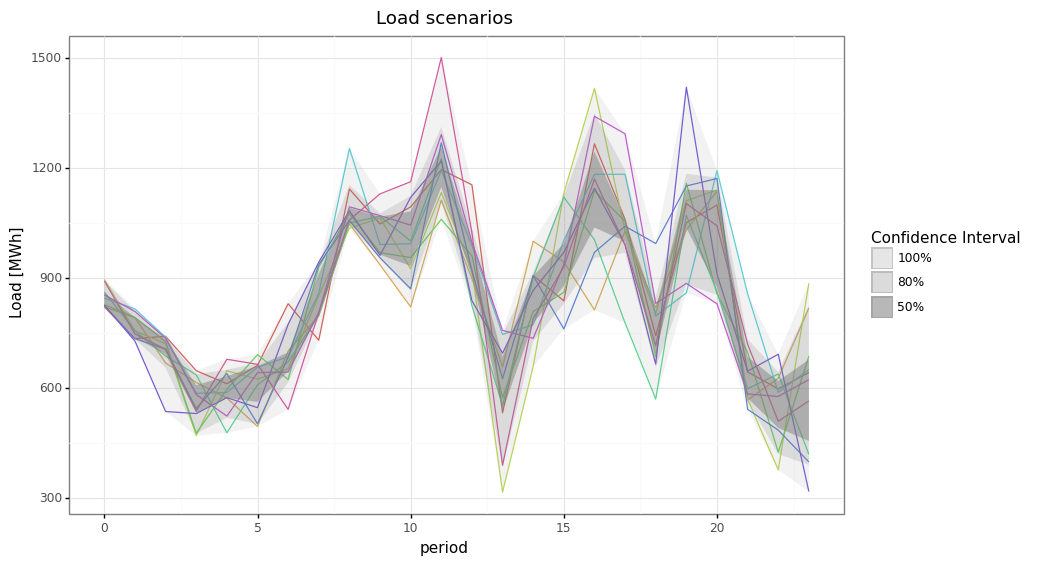

<ggplot: (8784847433975)>

In [6]:
scenarios = make_scenarios(data, noise_ratio=0.15, n=10)
charts.load(scenarios)

# Solution

In [7]:
stoch_ucp = stoch_modeller.create_model(data, scenarios)

In [ ]:
stoch_ucp.model.solve()
print(f"Cost: {stoch_ucp.model.objective.value()}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ataverna/pyvenv/lagrangian_example/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/cd7a9c5a6288452b9ab9f4f72e57e7f9-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/cd7a9c5a6288452b9ab9f4f72e57e7f9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6445 COLUMNS
At line 27296 RHS
At line 33737 BOUNDS
At line 34458 ENDATA
Problem MODEL has 6440 rows, 3600 columns and 16290 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 145726 - 0.07 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 264 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 147 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 40 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 38 strengthened rows, 0 substitutions
Cgl00

# Output

In [ ]:
solution = extract_solution(stoch_ucp)

In [ ]:
plots = [charts.total_production(data, solution),
 charts.enp_vs_eie(data, scenarios, solution),
 charts.electricity_prices(data, scenarios, solution, stoch_ucp),
 charts.production_by_plant(data, solution),
 charts.plant_utilization(data, solution)]

for p in plots:
    print(p)

In [ ]:
stoch_eval = evaluate_solution(data, scenarios, solution, stoch_ucp)

In [ ]:
def get_deterministic_evaluation(data):
    ucp = modeller.create_model(data)
    ucp.solve(PULP_CBC_CMD(msg=0))
    solution = extract_solution(ucp)
    cost = solution["total_production_cost"]
    evaluation = evaluate_solution(data,scenarios, solution, stoch_ucp)
    
    return cost, evaluation

det_cost, det_eval = get_deterministic_evaluation(data)

In [ ]:
charts.compare_deterministic_stochastic(det_cost, det_eval, stoch_eval)